In [ ]:
# imports

In [1]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [52]:
class Sirs:
    def __init__(self, i0, fa=(lambda t: 4), b=2, c=.5, d=0, dI=0, e=0, f=(lambda t: 0)):
        self.N = 1
        self.S = 1 - i0
        self.I = i0
        self.R = 0
        self.fa = fa
        self.b = b
        self.c = c
        self.d = d
        self.dI = dI
        self.e = e
        self.f = f
        
    def S_dot(self, ti, Si):
        return self.c*self.R - self.fa(ti)*Si*self.I/self.N - self.d*Si + self.e*self.N - self.f(ti)
    
    def I_dot(self, ti, Ii):
        return self.fa(ti)*self.S*Ii/self.N - (self.b + self.d + self.dI)*Ii
    
    def R_dot(self, ti, Ri):
        return self.b*self.I - (self.c + self.d)*Ri + self.f(ti)
    
    def N_dot(self, ti, Ni):
        return self.e*Ni - self.d*self.N - self.dI*self.I
    
    def update(self, new_vals):
        S, I, R, N = new_vals
        self.S = S
        self.I = I
        self.R = R
        self.N = N
        
    def fractions(self):
        a = self.fa(0)
        s = self.b/a
        i = (1 - self.b/a)/(1 + self.b/self.c)
        r = 1 - s - i
        return (s, i, r)

In [73]:
class SirsSolver:
    def __init__(self, sirs):
        self.sirs = sirs
        self.fs = {'S':sirs.S_dot, 'I':sirs.I_dot, 'R':sirs.R_dot, 'N':sirs.N_dot}
        self.res = {'S':None, 'I':None, 'R':None, 'N':None}
        self.t = self.h = None

    def get_fractions(self):
        N = self.res['N']
        return (self.res['S']/N, self.res['I']/N, self.res['R']/N)
        
    def _init_run(self, n_iter):
        self.res['S'] = np.ndarray(n_iter+1)
        self.res['I'] = np.ndarray(n_iter+1)
        self.res['R'] = np.ndarray(n_iter+1)
        self.res['N'] = np.ndarray(n_iter+1)
        self.res['S'][0] = sirs.S
        self.res['I'][0] = sirs.I
        self.res['R'][0] = sirs.R
        self.res['N'][0] = sirs.N
    

    def _rk4(self, code, i):
        f = self.fs[code]
        yi = self.res[code][i-1]
        ti = self.t[i]
        h = self.h
        
        k1 = h*f(ti, yi)
        k2 = h*f(ti+.5*h, yi+.5*k1)
        k3 = h*f(ti+.5*h, yi+.5*k2)
        k4 = h*f(ti+h, yi+k3)
        
        return max(0, yi + (k1 + 2*k2 + 2*k3 + k4)/6)

    
    def run_rk4(self, t_max=10, n_iter=100):
        self.t = np.linspace(0, t_max, n_iter+1)
        self.h = t_max/n_iter
        self._init_run(n_iter)
        for i in range(1, n_iter+1):
            self.res['S'][i] = self._rk4('S', i)
            self.res['I'][i] = self._rk4('I', i)
            self.res['N'][i] = self._rk4('N', i)
            self.res['R'][i] = self.res['N'][i] - self.res['S'][i] - self.res['I'][i]
            new_vals = (self.res['S'][i], self.res['I'][i], self.res['R'][i], self.res['N'][i])
            self.sirs.update(new_vals)

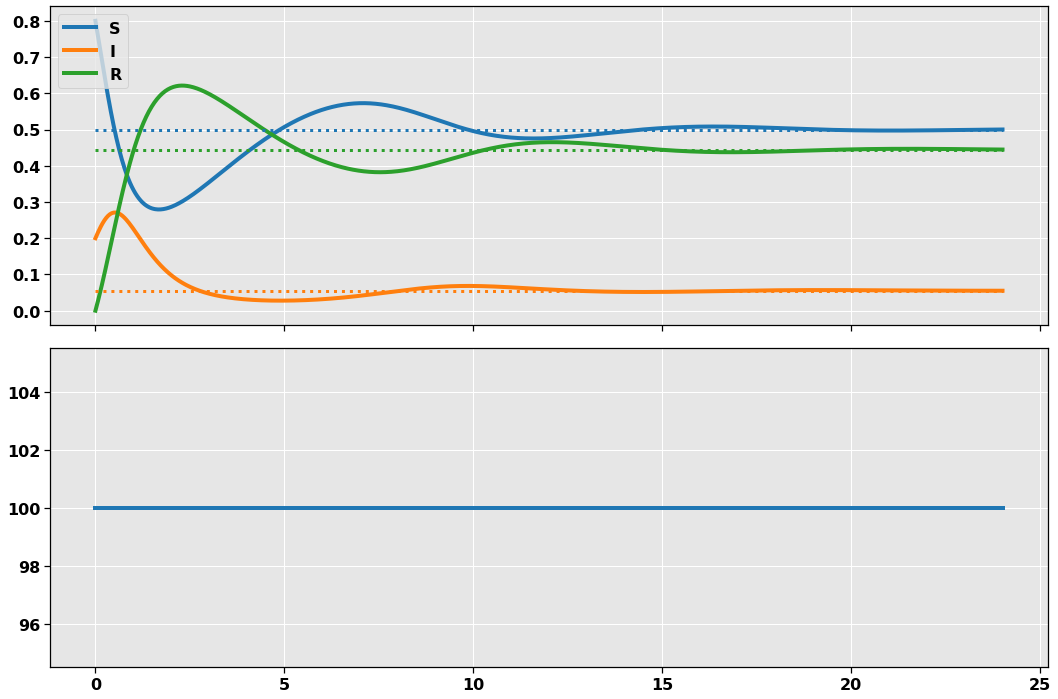

In [111]:
i0 = .2
b = 2
c = .25
e = .00
d = .00
dI = .0

#fa = (lambda t: 4 + 2*np.cos((2*np.pi/10)*(t)))
fa = (lambda t: 4)
#f = (lambda t: .05 + .02*np.cos((2*np.pi/10)*(t)))
f = (lambda t: .0)
sirs = Sirs(i0, fa=fa, b=b, c=c, e=e, d=d, dI=dI, f=f)

tn = 24
n = 1000
solver = SirsSolver(sirs)
solver.run_rk4(tn, n)

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(15,10))
ax = axes[0]
S, I, R = solver.get_fractions()
ax.plot(solver.t, S)
ax.plot(solver.t, I)
ax.plot(solver.t, R)
ax.legend(['S', 'I', 'R'], loc='upper left')

if True:
    s, i, r = sirs.fractions()
    ax.plot(solver.t, np.zeros(n+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(solver.t, np.zeros(n+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(solver.t, np.zeros(n+1) + r, ':', color=COLORS[2], lw=3)

ax = axes[1]
ax.plot(solver.t, solver.res['N']*100)

plt.tight_layout()
plt.show()

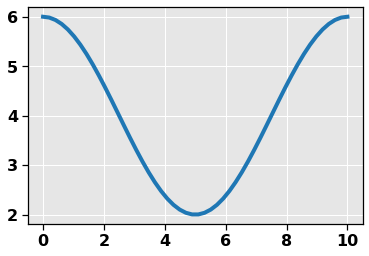

In [103]:
plt.plot(x:=np.linspace(0,10), fa(x))